In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# if con colab
#!unzip /Pokemon.zip -d /

In [3]:
project_name = 'pokenon_gan'

In [4]:
DATA_DIR = '/Pokemon'

In [5]:
print(os.listdir(DATA_DIR)[:5])

['Pokemon_images']


In [6]:
image_size = 128
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [7]:
train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

In [8]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [9]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=1, pin_memory=True)

In [10]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

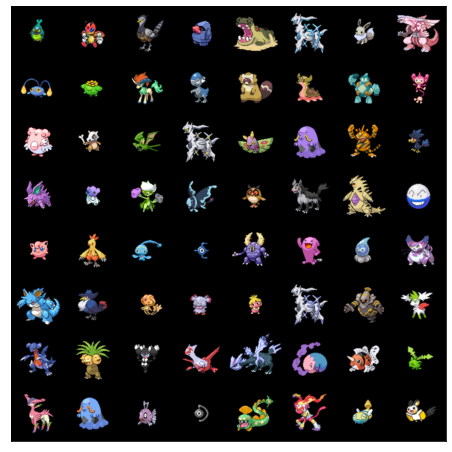

In [11]:
show_batch(train_dl)

In [12]:
#!pip install jovian --upgrade --quiet

In [13]:
#import jovian

In [14]:
#jovian.commit(project=project_name, environment=None)

In [15]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [16]:
device = get_default_device()
device

device(type='cuda')

In [17]:
train_dl = DeviceDataLoader(train_dl, device)

In [18]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, image_size, kernel_size=8, stride=2, padding=4, bias=False),
    nn.BatchNorm2d(image_size),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(image_size, 256, kernel_size=8, stride=2, padding=4, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=8, stride=2, padding=4, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(512, 1024, kernel_size=8, stride=2, padding=4, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(1024, 1, kernel_size=8, stride=2, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [19]:
x = torch.rand(1, 3, image_size, image_size)
discriminator(x).size()

torch.Size([1, 1])

In [20]:
discriminator = to_device(discriminator, device)

In [21]:
latent_size = 256

In [44]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 1024, kernel_size=8, stride=2, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(1024, 512, kernel_size=8, stride=2, padding=4, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(512, 256, kernel_size=8, stride=2, padding=4, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(256, image_size, kernel_size=16, stride=2, padding=4, bias=False),
    nn.BatchNorm2d(image_size),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(image_size, 3, kernel_size=22, stride=2, padding=4, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [45]:
x = torch.randn(1, latent_size, 1, 1)
x.size()

generator(x).size()

torch.Size([1, 3, 128, 128])

torch.Size([128, 3, 128, 128])


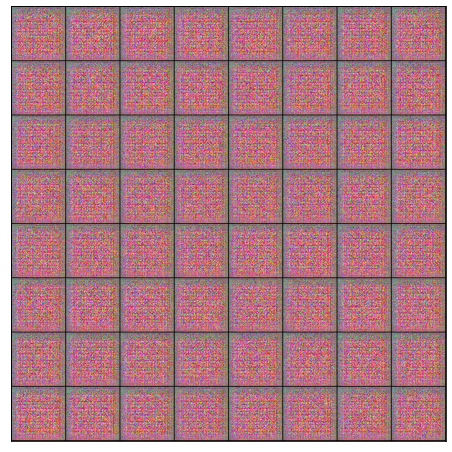

In [46]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors # with pi?
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [47]:
generator = to_device(generator, device)

In [48]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()
    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score # correggere con la % di beccate

In [49]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [50]:
sample_dir = '../results/generated'
os.makedirs(sample_dir, exist_ok=True)

In [51]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [52]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


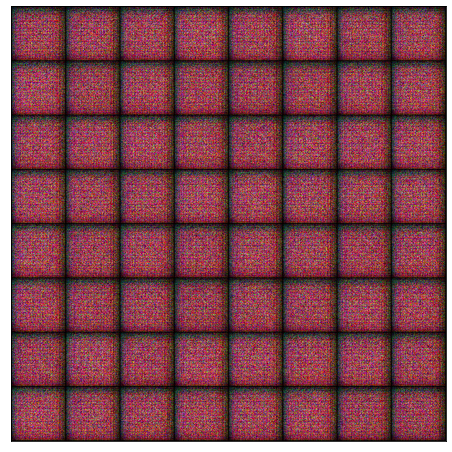

In [53]:
save_samples(0, fixed_latent)

In [60]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in tqdm(range(epochs)):
        for real_images, _ in train_dl:
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [61]:
lr = 1e-4
epochs = 10
# scheduler?

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 12.3390, loss_d: 0.0005, real_score: 0.9996, fake_score: 0.0001


 10%|█         | 1/10 [02:28<22:13, 148.19s/it]

Saving generated-images-0001.png
Epoch [2/10], loss_g: 11.7901, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


 20%|██        | 2/10 [04:58<19:55, 149.49s/it]

Saving generated-images-0002.png
Epoch [3/10], loss_g: 10.8262, loss_d: 0.0002, real_score: 1.0000, fake_score: 0.0002


 30%|███       | 3/10 [07:29<17:31, 150.28s/it]

Saving generated-images-0003.png
Epoch [4/10], loss_g: 9.5588, loss_d: 0.0219, real_score: 0.9996, fake_score: 0.0204


 40%|████      | 4/10 [10:01<15:04, 150.78s/it]

Saving generated-images-0004.png
Epoch [5/10], loss_g: 9.8168, loss_d: 0.0026, real_score: 0.9977, fake_score: 0.0003


 50%|█████     | 5/10 [12:33<12:35, 151.18s/it]

Saving generated-images-0005.png
Epoch [6/10], loss_g: 10.8523, loss_d: 0.0029, real_score: 0.9977, fake_score: 0.0005


 60%|██████    | 6/10 [15:05<10:05, 151.44s/it]

Saving generated-images-0006.png
Epoch [7/10], loss_g: 38.7921, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


 70%|███████   | 7/10 [17:37<07:34, 151.58s/it]

Saving generated-images-0007.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
from IPython.display import Image

In [ ]:
Image('./generated/generated-images-0060.png')

In [ ]:
vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores')